# **Emoji Classification Project - Computer Vision**

### Team Members : `Daniil NOTKIN`, `Yuhan SU` & `Yassine ERRAJI`

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## *Importations*

In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
from PIL import Image
from skimage import io, color
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


## *Functions*

In [3]:
import numpy as np
import cv2
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ---- Image loader: returns float32 RGB in 0..255, composited on white
def load_single_image_rgb255(path, bg=(255, 255, 255)):
    im = Image.open(path).convert("RGBA")
    rgba = np.array(im).astype(np.float32)  # 0..255

    rgb = rgba[..., :3]
    a = rgba[..., 3:4] / 255.0
    bg = np.array(bg, dtype=np.float32).reshape(1, 1, 3)
    rgb = rgb * a + bg * (1.0 - a)

    return rgb  # float32, 0..255


# ---- Generator: OpenCV aug -> preprocess_input -> yield AFTER batch filled
def imageLoader(
    files,
    labels,                 # dict: {img_id_str: label_name}
    batch_size,
    target_size=(72, 72),
    augment=False,
    class_weight_dict=None, # dict: {class_index: weight} OR None
    seed=42
):
    rng = np.random.default_rng(seed)
    files = np.array(files)
    L = len(files)

    # weight vector for fast sample_weight computation
    if class_weight_dict is not None:
        w_vec = np.array([float(class_weight_dict[i]) for i in range(num_classes)], dtype=np.float32)

    while True:
        order = rng.permutation(L)
        files_shuffled = files[order]

        for start in range(0, L, batch_size):
            batch_files = files_shuffled[start:start + batch_size]
            B = len(batch_files)

            X_batch = np.empty((B, target_size[1], target_size[0], 3), dtype=np.float32)
            Y_batch = np.zeros((B, num_classes), dtype=np.float32)

            for i, f in enumerate(batch_files):
                img_id = Path(f).stem
                if img_id not in labels:
                    raise KeyError(f"Missing label for image id {img_id}")

                img = load_single_image_rgb255(f)  # 0..255 float32
                img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)

                # geometric augmentation ONLY on raw numpy image
                if augment:
                    if rng.random() < 0.5:
                        img = cv2.flip(img, 1)
                    if rng.random() < 0.3:
                        angle = rng.uniform(-15, 15)
                        M = cv2.getRotationMatrix2D((target_size[0]//2, target_size[1]//2), angle, 1.0)
                        img = cv2.warpAffine(
                            img, M, dsize=target_size,
                            flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_REFLECT_101
                        )

                # MobileNetV2 preprocessing (expects 0..255)
                img = preprocess_input(img)

                X_batch[i] = img

                class_index = label_to_index[labels[img_id]]
                Y_batch[i, class_index] = 1.0

            # Yield only after full batch is prepared
            if class_weight_dict is None:
                yield X_batch, Y_batch
            else:
                sample_weight = Y_batch @ w_vec  # (B,)
                yield X_batch, Y_batch, sample_weight


### Dataset

In [4]:
PATH = Path("data")

In [5]:
train_dir = PATH / "train"
train_files = sorted([str(p) for p in train_dir.iterdir() if p.is_file()])

In [6]:
test_dir = PATH / "test"
test_files = sorted([str(p) for p in test_dir.iterdir() if p.is_file()])
test_ids = [Path(f).stem for f in test_files]

In [7]:
y_train_df = pd.read_csv(PATH / "train_labels.csv")

y_train_dct = dict(zip(y_train_df["Id"], y_train_df["Label"]))

In [8]:
gen = imageLoader(
    files=train_files,
    labels=y_train_dct,
    batch_size=32,
)

## Training

In [9]:
# ============================================================
# Train / Validation split
# ============================================================

# Split train files into train / validation
train_files_split, val_files_split = train_test_split(
    train_files,
    test_size=0.2,        # 80% train / 20% validation
    random_state=37,
    shuffle=True
)

print(f"Train samples: {len(train_files_split)}")
print(f"Validation samples: {len(val_files_split)}")

Train samples: 7903
Validation samples: 1976


In [10]:
unique_labels = y_train_df["Label"].unique().tolist()
unique_labels

['samsung', 'apple', 'facebook', 'google', 'messenger', 'whatsapp', 'mozilla']

### Label encoding (strings → integers)

Keras requires numeric labels.

In [11]:
# ============================================================
# Convert label dict keys to STRING to match Path(f).stem
# ============================================================

labels_str = {
    f"{int(k):05d}": v
    for k, v in y_train_dct.items()
}

In [12]:
# ============================================================
# Label encoding (string → integer)
# ============================================================

# Sorted for reproducibility
unique_labels = sorted(y_train_df["Label"].unique())

label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

num_classes = len(unique_labels)

print("Label to index mapping:")
print(label_to_index)

Label to index mapping:
{'apple': 0, 'facebook': 1, 'google': 2, 'messenger': 3, 'mozilla': 4, 'samsung': 5, 'whatsapp': 6}


In [13]:
# ============================================================
# Compute class weights to handle imbalance
# ============================================================

y_encoded = [label_to_index[label] for label in y_train_df["Label"]]

class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=y_encoded
)

class_weight = dict(enumerate(class_weights_array))

print("Class weights:")
print(class_weight)

Class weights:
{0: np.float64(0.7335164835164835), 1: np.float64(0.8466021081497986), 2: np.float64(0.7518837050003806), 3: np.float64(2.4332512315270938), 4: np.float64(3.5548758546239654), 5: np.float64(0.7884277733439745), 6: np.float64(0.8584462982273201)}


In [14]:
# Encode string labels to integers
label_to_index = {label: i for i, label in enumerate(unique_labels)}
index_to_label = {i: label for label, i in label_to_index.items()}

num_classes = len(unique_labels)
print(label_to_index)

{'apple': 0, 'facebook': 1, 'google': 2, 'messenger': 3, 'mozilla': 4, 'samsung': 5, 'whatsapp': 6}


### Define a compact, efficient CNN

This model:

•   Trains fast

•   Fits in memory

•   Should be enough for this task

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def build_model(input_shape=(72,72,3), num_classes=7, label_smoothing=0.05):
    base = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    base.trainable = False

    inputs = tf.keras.Input(shape=input_shape)

    # IMPORTANT: since preprocessing is done in generator, do NOT preprocess here.
    # Keep augmentation OFF at first to compare apples-to-apples with v3.
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(5e-4),
        loss=loss_fn,
        metrics=["accuracy"]
    )
    return model


### **Instantiate the model**

In [16]:
# ============================================================
# Instantiate model
# ============================================================

model = build_model(num_classes=num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 72, 72, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,839 (9.89 MB)

 Trainable params: 332,295 (1.27 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

### Train the model

We must define steps_per_epoch manually because we use a generator.

In [17]:
batch_size = 32
target_size = (72,72)

train_gen = imageLoader(
    files=train_files_split,
    labels=labels_str,
    batch_size=batch_size,
    target_size=target_size,
    augment=True,
    class_weight_dict=class_weight,   # set to None to disable
    seed=37
)

val_gen = imageLoader(
    files=val_files_split,
    labels=labels_str,
    batch_size=batch_size,
    target_size=target_size,
    augment=False,
    class_weight_dict=None,
    seed=123
)

steps_per_epoch = int(np.ceil(len(train_files_split) / batch_size))
validation_steps = int(np.ceil(len(val_files_split) / batch_size))

model = build_model(input_shape=(72,72,3), num_classes=num_classes)

history_phase1 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=15,
    verbose=1
)


Epoch 1/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 58s 172ms/step - accuracy: 0.2430 - loss: 2.0558 - val_accuracy: 0.4403 - val_loss: 1.5222
Epoch 2/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.4349 - loss: 1.4945 - val_accuracy: 0.5278 - val_loss: 1.3531
Epoch 3/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 76ms/step - accuracy: 0.5128 - loss: 1.3108 - val_accuracy: 0.5739 - val_loss: 1.2626
Epoch 4/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.5886 - loss: 1.1932 - val_accuracy: 0.6043 - val_loss: 1.1907
Epoch 5/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6122 - loss: 1.1225 - val_accuracy: 0.6245 - val_loss: 1.1644
Epoch 6/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6486 - loss: 1.0409 - val_accuracy: 0.6463 - val_loss: 1.1212
Epoch 7/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.6687 - loss: 1.0018 - val_accuracy: 0.6559 - val_loss: 1.1155
Epoch 8/15
247/247 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6826 - loss: 0.9529 -

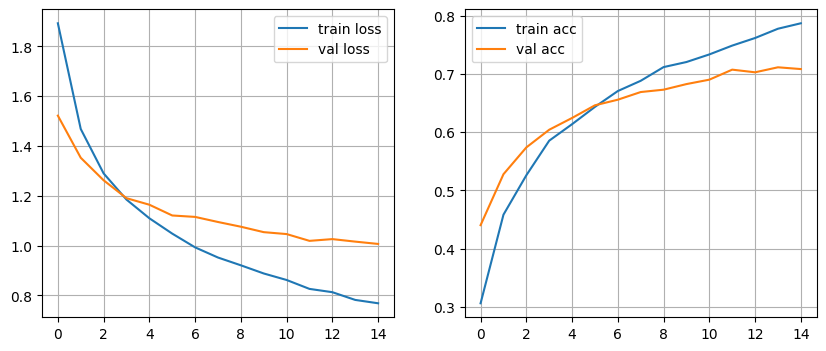

In [18]:
# plotting the changes after the fact

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_phase1.history["loss"], label="train loss")
plt.plot(history_phase1.history.get("val_loss", []), label="val loss")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_phase1.history["accuracy"], label="train acc")
plt.plot(history_phase1.history.get("val_accuracy", []), label="val acc")
plt.legend(); plt.grid()

plt.show()


In [ ]:
# ============================================================
# Fine-tuning - Phase 2
# ============================================================

import tensorflow as tf

# Number of layers to fine-tune from the end
FINE_TUNE_LAYERS = 100

# Freeze all layers first
for layer in model.layers:
    layer.trainable = False

# Unfreeze last N layers (except BatchNorm)
for layer in model.layers[-FINE_TUNE_LAYERS:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05)


# Recompile with lower learning rate (critical)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    # this code smoothes sparse categorical crossentropy loss
    # as opposed to merely declaring it
    loss = loss_fn,
    metrics=["accuracy"]
)

history_phase2 = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 102s 215ms/step - accuracy: 0.2534 - loss: 2.0187 - val_accuracy: 0.6630 - val_loss: 1.0984
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.3441 - loss: 1.6798 - val_accuracy: 0.6098 - val_loss: 1.1753
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.4043 - loss: 1.5244 - val_accuracy: 0.5749 - val_loss: 1.2484
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - accuracy: 0.4780 - loss: 1.3967 - val_accuracy: 0.5643 - val_loss: 1.2568
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.5291 - loss: 1.2972 - val_accuracy: 0.5703 - val_loss: 1.2477
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.5526 - loss: 1.2363 - val_accuracy: 0.6043 - val_loss: 1.1871
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.5790 - loss: 1.1892 - val_accuracy: 0.6240 - val_loss: 1.1524
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.6072 - loss: 1.1167

In [ ]:
# plotting the changes after the fact

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history_phase2.history["loss"], label="train loss")
plt.plot(history_phase2.history.get("val_loss", []), label="val loss")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(history_phase2.history["accuracy"], label="train acc")
plt.plot(history_phase2.history.get("val_accuracy", []), label="val acc")
plt.legend(); plt.grid()

plt.show()


### **We now replace the dummy prediction function**

In [ ]:
def predict_with_my_solid_model(test_files):
    preds = []
    for f in test_files:
        img = load_single_image_rgb255(f)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img = preprocess_input(img)
        probs = model.predict(img[None, ...], verbose=0)
        preds.append(index_to_label[int(np.argmax(probs, axis=1)[0])])
    return preds


### **Generate submission**

In [ ]:
y_test_pred = predict_with_my_solid_model(test_files)

test_ids_sr = pd.Series(test_ids, name="Id")
y_test_pred_sr = pd.Series(y_test_pred, name="Label")

submission_df = pd.concat([test_ids_sr, y_test_pred_sr], axis=1)
submission_df.head()

In [ ]:
submission_df.to_csv("submission.csv", index=False)